In [1]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from textblob import TextBlob

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)



nltk.download('punkt')


from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/tmp/ipykernel_28/359233670.py:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

# Load Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
import pandas as pd
data = pd.read_csv('/kaggle/input/brad-book-review/BRAD.tsv' , delimiter='\t' , header=None)

# Data Processing

In [4]:
data = data.drop(data.columns[1], axis=1)
data = data.drop(data.columns[1], axis=1)
data = data.drop(data.columns[1], axis=1)

In [5]:
data.head(2)

,0,4
0,4,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,5,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...


In [6]:
data = data.rename(columns={0:"label" , 4:"review"})

In [7]:
data.head(2)

,label,review
0,4,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,5,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...


In [8]:
data.label.value_counts()

5    166972
4    158462
3    106785
2     47133
1     31247
Name: label, dtype: int64

In [9]:
def count_diacritical_marks(texts):
    total = 0
    # use a regular expression to match the diacritical marks
    for text in texts:
        diacritical_marks = re.findall(r'[\u064B-\u065F]', text)
        # count the number of matches
        count = len(diacritical_marks)
        total = total + count
    return total

In [10]:
count =count_diacritical_marks(data['review']) 

In [11]:
print("Number of diacritical marks is " + str(count))

Number of diacritical marks is 1345161


In [12]:
data = data[data['label'] != 3]

In [13]:
data.label.value_counts()

5    166972
4    158462
2     47133
1     31247
Name: label, dtype: int64

In [14]:
def mark_sentiment(rating):
    if(rating<3):
        return 0
    else:
        return 1

In [15]:
data['label'] = data['label'].apply(lambda x:mark_sentiment(x))

In [16]:
data.head()

,label,review
0,1,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,1,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
2,1,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
3,1,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
5,1,رواية واقعية ورائعة تمثل أحداث تكررت كثيرا في ...


In [17]:
data['review'].duplicated().sum()


5422

In [18]:
data.drop_duplicates("review", inplace=True)

In [19]:
data.label.value_counts()

1    320762
0     77630
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

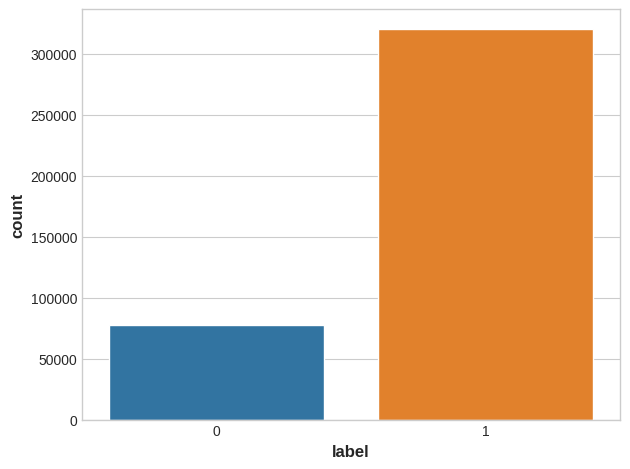

In [20]:
sns.countplot(x=data["label"])

# Balancing Data

In [21]:
datasetNeg , datasetPos, = (g for _,g in data.groupby('label'))

In [22]:
print(datasetNeg.shape)
datasetNeg.head()

(77630, 2)


,label,review
46,0,قرأتها من فترة طويلة و لا يحضرني فيها الا اعجا...
48,0,كان نفسي احب الرواية دي، أغلب اصدقائي اللي قرأ...
68,0,عملوا منها مسلسل. اجوف المسلسل ولا اقرى الرواي...
71,0,لطيفه :). كأنك بتتفرج ع مسلسل بس نوعا ما لطيف
73,0,الرواية جميلة تحمل معاني ورسالات كثيرة اراد ال...


In [23]:
print(datasetPos.shape)
datasetPos.head()

(320762, 2)


,label,review
0,1,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,1,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
2,1,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
3,1,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
5,1,رواية واقعية ورائعة تمثل أحداث تكررت كثيرا في ...


In [24]:
datasetNeg = datasetNeg.iloc[0 :70000 ]
datasetPos = datasetPos.iloc[0 :80000 ]

In [25]:
data = pd.concat([datasetPos,datasetNeg])

In [26]:
print(data.shape)
data.head()

(150000, 2)


,label,review
0,1,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,1,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
2,1,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
3,1,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
5,1,رواية واقعية ورائعة تمثل أحداث تكررت كثيرا في ...


In [27]:
data.label.value_counts()

1    80000
0    70000
Name: label, dtype: int64

In [28]:
text_len = []
for text in data.review:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
    
data['text_len'] = text_len

In [29]:
stops = set(stopwords.words("arabic"))
stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","كان","ّأيّان"}

st = ISRIStemmer()
def stemNLTK(text):
    # tokenize
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ty = st.stem(w)
        cleaned.append(ty)
    return " ".join(cleaned)


def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)


def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in stops and not w in stop_word_comp and len(w) >= 2])



def clean_text(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    ## Convert text to lowercases
    text = text.lower()
    ## Remove stop words
    text = remove_stop_words(text)
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    #text = normalizeArabic(text)
    #text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    #Stemming
    text = stemNLTK(text)
    return text

In [30]:
data['review'] = data['review'].apply(lambda x:clean_text(x))

## Split the dataset into training and testing sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42)

# Tokenize the text data

In [32]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sequences to the same length


In [33]:
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

## Load the GloVe word embeddings

In [34]:
embedding_dict = {}
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = coeffs

# Create the embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create LSTM Model

## Define the LSTM model

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))

## Compile the model


In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Convert the labels to one-hot encoding

In [37]:
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [38]:
from keras.callbacks import EarlyStopping
history = model.fit(X_train, y_train, epochs=10, batch_size=1024 , validation_split=0.1,
                   verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
106/106 [==============================] - 92s 797ms/step - loss: 0.4852 - accuracy: 0.7572 - val_loss: 0.3819 - val_accuracy: 0.8348
Epoch 2/10
106/106 [==============================] - 70s 662ms/step - loss: 0.3599 - accuracy: 0.8454 - val_loss: 0.3823 - val_accuracy: 0.8384
Epoch 3/10
106/106 [==============================] - 64s 605ms/step - loss: 0.3414 - accuracy: 0.8559 - val_loss: 0.3801 - val_accuracy: 0.8386
Epoch 4/10
106/106 [==============================] - 62s 586ms/step - loss: 0.3278 - accuracy: 0.8631 - val_loss: 0.3786 - val_accuracy: 0.8377
Epoch 5/10
106/106 [==============================] - 62s 584ms/step - loss: 0.3125 - accuracy: 0.8693 - val_loss: 0.3703 - val_accuracy: 0.8381
Epoch 6/10
106/106 [==============================] - 61s 572ms/step - loss: 0.2974 - accuracy: 0.8765 - val_loss: 0.3864 - val_accuracy: 0.8357
Epoch 7/10
106/106 [==============================] - 60s 567ms/step - loss: 0.2822 - accuracy: 0.8835 - val_loss: 0.3969 - val_ac

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
yy_test = np.argmax(y_test, axis=1)
print(classification_report(yy_test, y_pred))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))

938/938 [==============================] - 34s 36ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     14066
           1       0.84      0.84      0.84     15934

    accuracy                           0.83     30000
   macro avg       0.83      0.83      0.83     30000
weighted avg       0.83      0.83      0.83     30000

Test Accuracy: 0.8317


In [40]:
def predict_sentiment(tweet):
    tweet = re.sub(r'[^\w\s]', '', tweet.lower())
    tweet_sequence = tokenizer.texts_to_sequences([tweet])
    tweet_padded = pad_sequences(tweet_sequence, maxlen=max_length)
    sentiment = model.predict(tweet_padded)[0]
    if np.argmax(sentiment) == 0:
        return "negative"
    else:
        return "positive"


In [41]:
# Example usage
new_tweet = input("Enter a new tweet: ")
predicted_sentiment = predict_sentiment(new_tweet)
print("Predicted sentiment:", predicted_sentiment)

Enter a new tweet:  الكتاب شكله جميل جدا


1/1 [==============================] - 0s 55ms/step
Predicted sentiment: positive


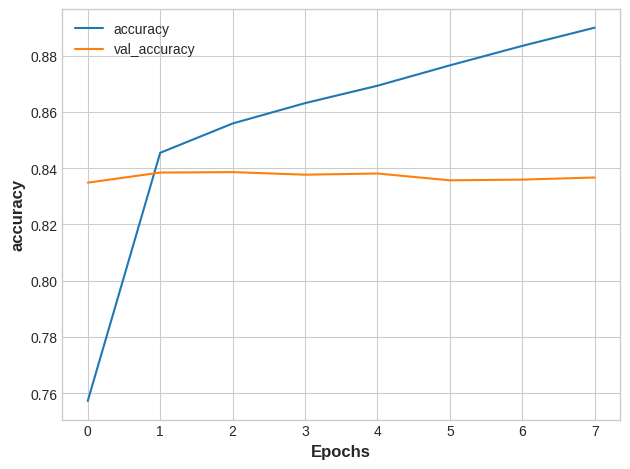

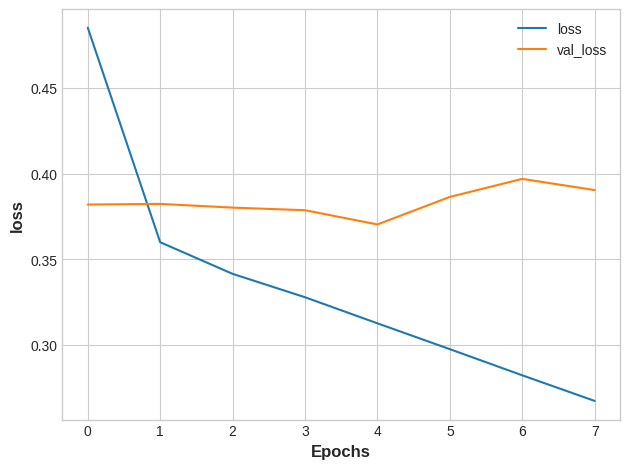

In [42]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Confusion Matrix for LSTM Model

In [43]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

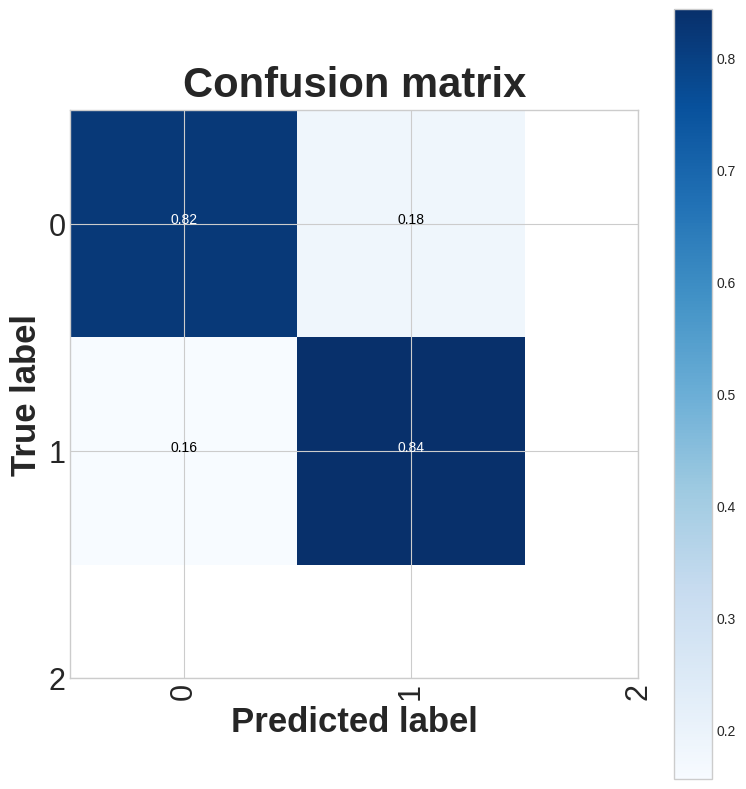

In [44]:
import itertools
cnf_matrix = confusion_matrix(yy_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes={0,1,2}, title="Confusion matrix")
plt.show()